<a href="https://colab.research.google.com/github/vitorgaboardi/data-science/blob/master/1FP_Google_Mobility_Report.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#1.0 Import libraries and Dataset


In [19]:
import pandas as pd
import pandas_profiling
import math
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection

In [9]:
data = pd.read_csv("https://www.gstatic.com/covid19/mobility/Global_Mobility_Report.csv")

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (4) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


#2.0 Pre-processing and cleaning


In [10]:
data_br = data.loc[data.country_region == "Brazil",:].iloc[:,[1,2,3,7,8,9,10,11,12,13]].copy()
data_br.columns = ["country","state","city","date","retail","grocery","parks","transit","workplaces","residential"]
data_br.date = pd.to_datetime(data_br.date)
data_br.index = data_br.date
data_br.drop(labels="date",axis=1,inplace=True)
data_br.head()

,country,state,city,retail,grocery,parks,transit,workplaces,residential
date,,,,,,,,,
2020-02-15,Brazil,NaN,NaN,5.0,4.0,-5.0,8.0,6.0,0.0
2020-02-16,Brazil,NaN,NaN,2.0,3.0,-13.0,3.0,0.0,1.0
2020-02-17,Brazil,NaN,NaN,-2.0,0.0,-12.0,9.0,19.0,-1.0
2020-02-18,Brazil,NaN,NaN,-3.0,-1.0,-11.0,9.0,15.0,-1.0
2020-02-19,Brazil,NaN,NaN,-1.0,-2.0,-5.0,8.0,14.0,-1.0


In [11]:
data_br.state = data_br.state.str.replace("State of ","")
data_br_state = data_br.loc[~data_br.state.isnull() & data_br.city.isnull()]
data_br_state.head()

,country,state,city,retail,grocery,parks,transit,workplaces,residential
date,,,,,,,,,
2020-02-15,Brazil,Federal District,NaN,10.0,7.0,-8.0,8.0,8.0,0.0
2020-02-16,Brazil,Federal District,NaN,11.0,6.0,-10.0,4.0,0.0,2.0
2020-02-17,Brazil,Federal District,NaN,2.0,4.0,-1.0,11.0,22.0,-2.0
2020-02-18,Brazil,Federal District,NaN,1.0,4.0,2.0,14.0,22.0,-2.0
2020-02-19,Brazil,Federal District,NaN,-2.0,0.0,-3.0,9.0,20.0,-2.0


#3.0 Figure

First, we will group together the states that belong to the same region and specify the item that we want to analyze

In [26]:
item = "retail"

northeast = ["Bahia","Sergipe","Alagoas","Pernambuco","Paraíba","Rio Grande do Norte","Ceará","Piauí","Maranhão"]
north = ["Tocantins","Pará","Amazonas","Amapá","Roraima","Acre","Rondônia"]
midwest = ["Federal District","Goiás","Mato Grosso","Mato Grosso do Sul"]
southeast = ["São Paulo", "Rio de Janeiro","Minas Gerais","Espírito Santo"]
south = ["Rio Grande do Sul","Santa Catarina", "Paraná"]

regions = [northeast, southeast, south, north, midwest]
subtitles = ["Northeast","Southeast", "South","North","Midwest"]

Now, we will create the image with the moving average (7 days) for each of these regions considering the specified item. The blue line is the average of all the states from the respective region, while the gray lines represent each state. 

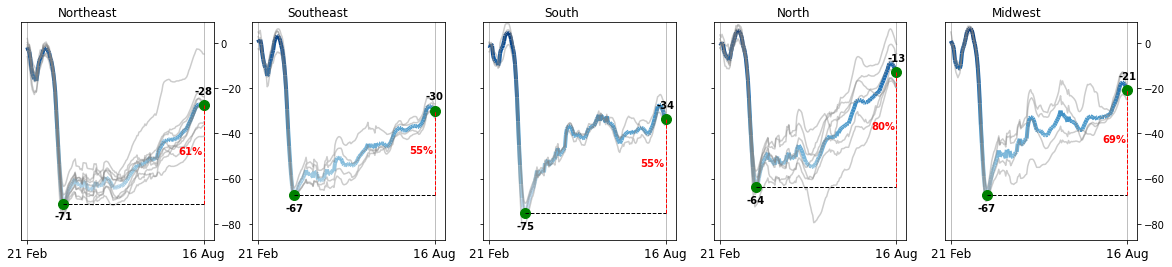

In [28]:
fig, ax = plt.subplots(nrows=1,ncols=5,figsize=(20,4))

## Min and max values in the y-axis
y_min = int(math.floor(data_br_state[item].rolling(window=7).mean().min()))
y_max = int(math.ceil(data_br_state[item].rolling(window=7).mean().max()))

for i,region in enumerate(regions):
  rows = data_br_state.groupby(by=[data_br_state.index,"state"]).mean().unstack()[item][region].shape[0]
  data_br_state.groupby(by=[data_br_state.index,"state"]).mean().unstack()[item][region].rolling(window=7).mean().set_index(pd.Index(range(rows))).plot(legend=False,color="grey",linewidth=1.5,alpha=0.4,ax=ax[i])
  
  region_avg = data_br_state.groupby(by=[data_br_state.index,"state"]).mean().unstack()[item][region].mean(axis=1).rolling(window=7).mean()
  x = np.array(list(range(len(region_avg))))          #x will be an integer array
  y = np.array(region_avg.to_list())

  # Line varying color
  points = np.array([x, y]).T.reshape(-1, 1, 2)
  segments = np.concatenate([points[:-1], points[1:]], axis=1)
  norm = plt.Normalize(-100, 10)  
  lc = LineCollection(segments, cmap='Blues', norm=norm)
  lc.set_array(y)
  lc.set_linewidth(4)

  ax[i].add_collection(lc)


  ## Plot configuration
  # X Label
  x_min = 6                      # start index of the moving average
  x_max = pd.DataFrame(y).apply(pd.Series.last_valid_index).to_list()[0]
  day_first = region_avg.index.to_list()[6].strftime("%d %b") #string!
  day_last = region_avg.last_valid_index().strftime("%d %b")

  ax[i].set_xlabel("")
  ax[i].set_xticks([x_min, x_max]) 
  ax[i].set_xticklabels([day_first, day_last],fontsize=12)

  # Axis
  ax[i].set_xlim(0, x_max+10)
  ax[i].set_ylim(y_min-5, y_max)

  ax[i].set_title(subtitles[i],fontsize=12,ha='right')
  ax[i].xaxis.grid(True)
  ax[i].set_xlabel("")

  ## Plot points
  # Min value
  idx_min = np.nanargmin(y)
  ax[i].plot(x[idx_min],y[idx_min],'o', color='green', markersize=10)
  ax[i].text(x[idx_min],y[idx_min]-7,"{:.0f}".format(y[idx_min]), fontweight='bold', horizontalalignment='center')

  # Current value
  ax[i].plot(x_max,y[x_max],'o', color='green', markersize=10)
  ax[i].text(x_max,y[x_max]+5,"{:.0f}".format(y[x_max]), fontweight='bold', horizontalalignment='center')


  ## Lines
  # Black line
  ax[i].plot([x[idx_min], x_max], [y[idx_min], y[idx_min]], 'k--', linewidth=1)

  # Red line
  ax[i].plot([x_max, x_max], [y[idx_min], y[x_max]], 'r--', linewidth=1)
  ax[i].text(x_max-1, y[x_max] - (y[x_max]-y[idx_min])/2, "{:.0f}".format(-((y[x_max]-y[idx_min])/y[idx_min])*100)+"%", fontweight='bold', color = 'red', horizontalalignment='right')

  if (i==0) or (i==4):
    ax[i].yaxis.tick_right()
  else:
    ax[i].set_yticklabels([])

plt.savefig("regioes.png",dpi=300)
plt.show()